In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import pathlib
import pandas as pd

AUTOTUNE = tf.data.experimental.AUTOTUNE

In [2]:
import sys
sys.path.append('..')
from utilities import Timer

# Load data as a TensorFlow dataset

Largely based on the TensorFlow [tutorial](https://www.tensorflow.org/tutorials/load_data/images)

In [3]:
width = height = 224
batch_size = 128

In [4]:
# Load the classnames

df = pd.read_excel('../dataset/artist-breakdown-annotated.xlsx')
df = df[df.fillna(0).keep.astype(bool)]
class_names = df.artist.unique()
class_names.sort()

In [5]:
def load_dataset(data_subdir, 
                 shuffle = True, shuffle_buffer_size=1000,
                 batch_size = batch_size,
                 width      = width,
                 height     = height
                ):
    # Load the list of file names in the form of data_dir/class_name/file_name.jpg
    data_dir = pathlib.Path('../dataset/images/') / pathlib.Path(data_subdir)
    list_ds = tf.data.Dataset.list_files(str(data_dir/'*/*'))

    dataset_size = len(list(list_ds))
    
    # Function to get the label
    def get_label(file_path):
        parts = tf.strings.split(file_path, os.path.sep)
        return parts[-2] == class_names
    
    # Function to get the image
    def decode_img(file_path):
        # Load the image
        img = tf.io.read_file(file_path)
        img = tf.image.decode_jpeg(img, channels=3)
        
        # Scale image pixels to 0/1
        img = tf.image.convert_image_dtype(img, tf.float32)
        # Resize
        return tf.image.resize(img, [width, height])
    
    # Combine both processes
    def process_path(file_path):
        return decode_img(file_path), get_label(file_path)
    
    # Create the dataset
    ds = list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
    ds = ds.cache()
    
    if shuffle:
        if shuffle_buffer_size is not None:
            ds = ds.shuffle(buffer_size = shuffle_buffer_size)
        else:
            ds = ds.shuffle(buffer_size = dataset_size)
    
    ds = ds.repeat().batch(batch_size).prefetch(buffer_size = AUTOTUNE)    
    return ds, dataset_size

In [7]:
# Look at a batch
peek, peek_size = load_dataset('train', shuffle_buffer_size=32)
image_batch, label_batch = next(iter(peek))

def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(25):
        ax = plt.subplot(5,5,n+1)
        plt.imshow(image_batch[n])
        plt.title(class_names[label_batch[n]==1][0].title())
        plt.axis('off')

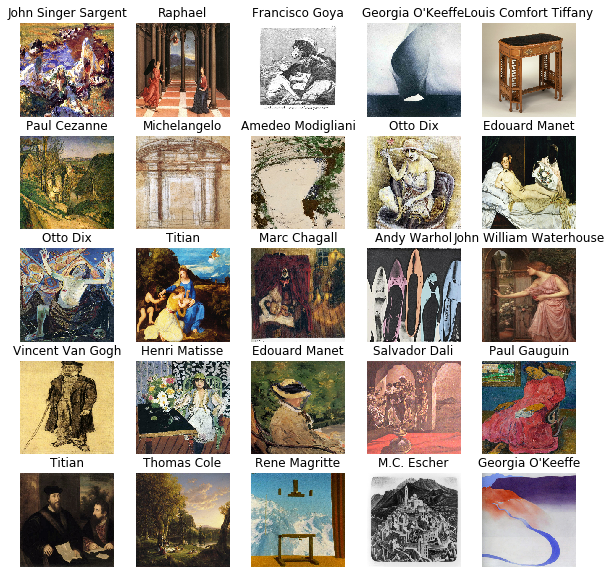

In [8]:
show_batch(image_batch.numpy(), label_batch.numpy())